# Evolution de l'émission du centre galactique et de l'émission diffuse

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

# Début de l'analyse (avec mapdatasets déjà écrits)

## Création de la géométrie

In [3]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.1, 200, 20, unit="TeV", name="energy", interp="log"
)

## Lecture des cartes

In [4]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapsdataset_bkg-peak/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(filename)

## Modèle de la source

In [5]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

spatial_model = PointSpatialModel(
            lon_0 = src_pos.l, 
            lat_0 = src_pos.b, 
            frame = "galactic")

spectral_model = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "2.9e-12 cm-2 s-1 TeV-1")

model = SkyModel(
            spatial_model = spatial_model, 
            spectral_model = spectral_model, 
            name = "SgrA*")

model.parameters["index"].frozen = True
model.parameters["lon_0"].frozen = True
model.parameters["lat_0"].frozen = True
model.parameters["amplitude"].frozen = False
model.parameters["reference"].frozen = True # change très peu

In [6]:
pos_G09 = SkyCoord(0.8791,  +0.0893, unit="deg", frame="galactic")

spatial_model2 = PointSpatialModel(
            lon_0 = pos_G09.l, 
            lat_0 = pos_G09.b, 
            frame = "galactic")

spectral_model2 = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "0.88e-12 cm-2 s-1 TeV-1")

modelG09 = SkyModel(
            spatial_model = spatial_model2, 
            spectral_model = spectral_model2, 
            name = "G0901")

modelG09.parameters["index"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

In [7]:
print(modelG09)

SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 8.791e-01   nan            deg        nan       nan   True
    lat_0 8.930e-02   nan            deg -9.000e+01 9.000e+01   True
    index 2.300e+00   nan                       nan       nan   True
amplitude 8.800e-13   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True


## Modèle de l'émission diffuse

On suit larticle de 2018 et on la constitue de 3 composantes. Une qui suit la distribution de gaz (CS) une composante radiale centrale et un composante étendue. On veut fixer leur flux relatif et seulement ajuster un seul facteur de normalisation pour les trois à la fois.

On a les composantes : DGC (Dense Gas Component), CC (Central Component) et LSC (Large Scale Component).

- on prend une carte de la distribution du CS comme base
- on applique une gaussienne pour "atténuer" les bords, car l'émission de rayons gamma suit la distribution du CS à part aux extrémités du "disque centrale"
- on choisit 1.11 deg comme écart-type de la gaussienne
- on seuil les valeurs de la cartes du CS, car celles-ci viennent de données bruitées qui peuvent prendre des valeurs négatives, on veut a priori seuiller un peu au dessus de zéro pour éliminer le bruit autour de zéro
- valeur du seuil : 10
- le fait d'utiliser TemplateSpatialModel en 0.15 conduit à normaliser les valeurs de la carte par leur somme (normal car on va fiter son amplitude), mais aussi par la somme des angles solides, ce qui fait que le spectre obtenu est en sr-1 emais ce n'est précisé nulle part

In [8]:
# GaussianSpatialModel attention pour la composante étendue et les deux sigma

#rajouter une source ponctuelle pour G0901 (PWN flux stable a priori)

CSmap = Map.read("$GAMMAPY_DATA/CS_reproj.fits") 
# à moduler par une gaussienne en longitude
coords = CSmap.geom.get_coord()
lon = coords.skycoord.l.wrap_at(180*u.deg).to_value('deg')
factor = np.exp(-0.5*(lon)**2/0.8**2) #1.11 quand on a les 3 composantes


# seuiller les valeurs pour enlever les valeurs négatives liées au bruit
CSmap.data*=factor
CSmap.data = CSmap.data.clip(10.0)

# utile pour retrouver la bonne valeur du flux diffus (intégré sur l'angle solide)
solid_angle_tot = CSmap.geom.solid_angle().sum()

geom1000 = CSmap.geom

Invalid value BUNIT='Count' in FITS header. Setting empty unit.


In [9]:
DGC = TemplateSpatialModel(CSmap) 

CC = GaussianSpatialModel(sigma=0.11*u.deg) #sigma de 0.11

LSC = GaussianSpatialModel(sigma=0.97*u.deg, e=0.226) #sigma1 de 0.97 et sigma2 de 0.22, à transformer en sigma et excentricité

# essayer de rassembler les gaussiennes dans un TemplateSpatialModel, voire dans celle de la CSMap

In [10]:
# on tente de combiner les trois composantes dans une seule carte

mapCC = CC.evaluate_geom(geom1000)
mapLSC = LSC.evaluate_geom(geom1000)
data_combine = 1.03*mapCC.value + 2.68*mapLSC.value + 4.3*CSmap.data

In [11]:
CSmap.data = data_combine

DE_spatial = TemplateSpatialModel(CSmap) 

In [12]:
powerlaw1 =  PowerLawSpectralModel(
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "1.0e-12 cm-2 s-1 TeV-1")

model_diff = SkyModel(
            spatial_model = DE_spatial, 
            spectral_model = powerlaw1, 
            name = "DE_full")

model_diff.parameters["index"].frozen = True
model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f6d5af66cc0>)

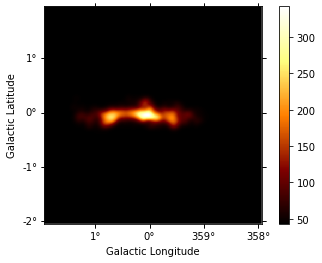

In [53]:
CSmap.cutout(src_pos,4*u.deg).smooth(width=0.05*u.deg).plot(add_cbar=True)

## Construction du masque

In [13]:
fit_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)

bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.4 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([bizarre_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

# Ajustement du modèle aux cartes

Pour les cartes fabriquées avec le FOVBackgroundMaker : 
- si la norm du background est frozen = emission diffuse est négative
- si la norm du background est pas frozen = emission diffuse est négative au premier essai
- emission diffuse est idem au deuxième essai
- emission diffuse est idem   au troisième essai
- si la norm du background est pas frozen ET qu'on ne refixe pas norm à 1 = emission diffuse est ok/bof au quatrième essai
- si on le refait (toujours sans toucher à la norm mais avec reset des 2 modèles) = c'est bon


En gros, faire le fit une première fois pour avoir la norm juste, puis, sans toucher à la norm, remettre les deux modèles à zéro et refaire le fit, deux fois

si on refait le fit sans mettre les modèles à zéro ? ça change rien (logique car à cette étape le fit est censé être correct)

In [14]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[12]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov, result

def fit_dataset_contour(mapdataset):
    fit = Fit([mapdataset])

    fit.optimize()
    res = fit.minos_contour(3, 7)
   
    return res

In [15]:
%%time

for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  model.copy() + modelG09.copy()+ model_diff.copy()
    mapdataset_dict[year].background_model.parameters['norm'].value = 1.0
    #mapdataset_dict[year].background_model.parameters['norm'].frozen = True

CPU times: user 6.55 s, sys: 3.99 ms, total: 6.56 s
Wall time: 6.56 s


In [16]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov, result = fit_dataset(mapdataset_dict[year])
    
    results.append(result)
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

CPU times: user 13min, sys: 29 s, total: 13min 29s
Wall time: 13min 29s


In [17]:
results

[OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 114
 	total stat : 453654.04, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 117
 	total stat : 509291.84, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 108
 	total stat : 260401.64, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 115
 	total stat : 100619.88, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 99
 	total stat : 149136.41, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimizat

In [18]:
np.sqrt(np.abs(cov_per_year[2004]))

array([[8.19228403e-14, 4.92483258e-13, 1.23564394e-08],
       [4.92483258e-13, 1.02518834e-11, 2.69831880e-07],
       [1.23564394e-08, 2.69831880e-07, 7.84838965e-03]])

### Sauvegarde des modèles par année

In [19]:
for year in range(2004,2020):
    mapdataset_dict[year].models.write("../../../hess_results/DE_3comp_in1_bkg-peak/models/model"+ str(year), overwrite=True)

### Affichage et sauvegarde des résidus

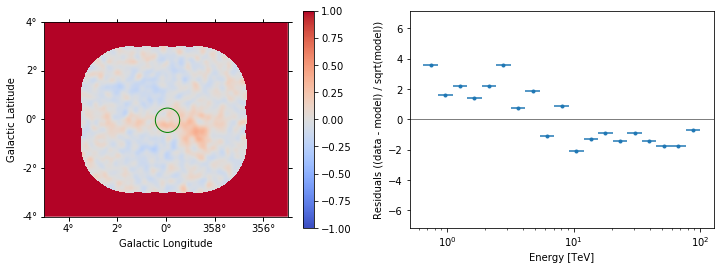

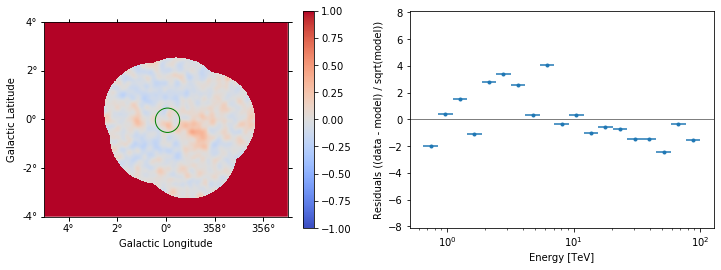

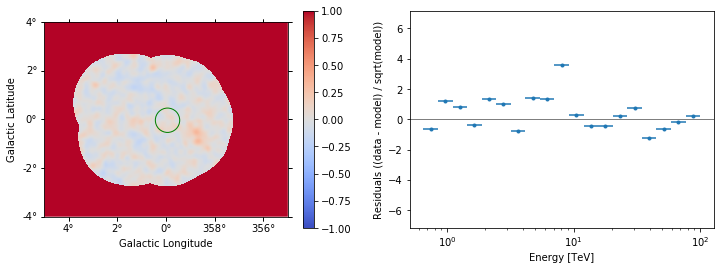

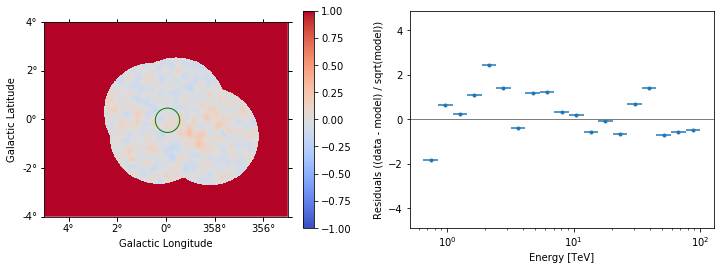

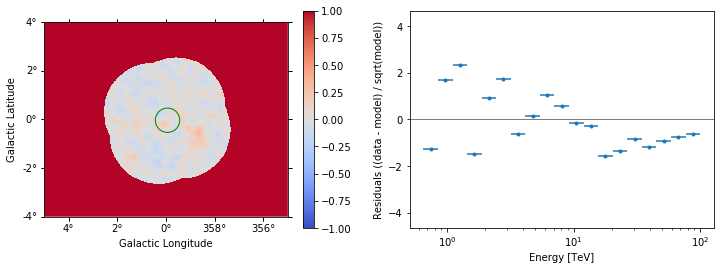

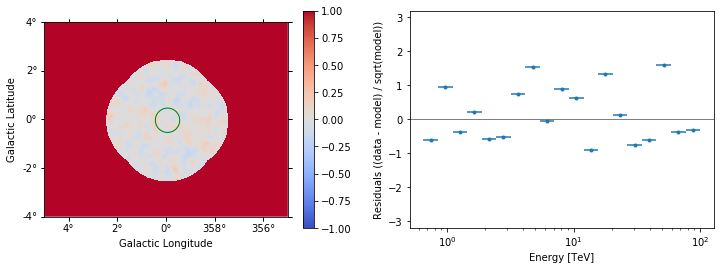

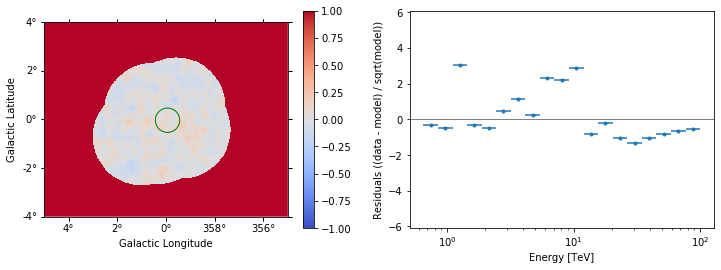

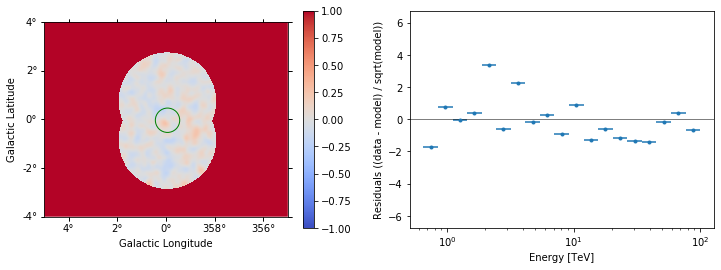

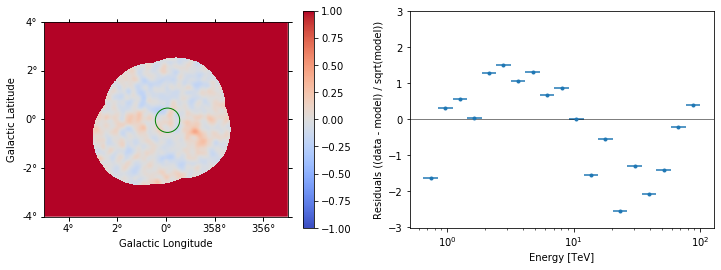

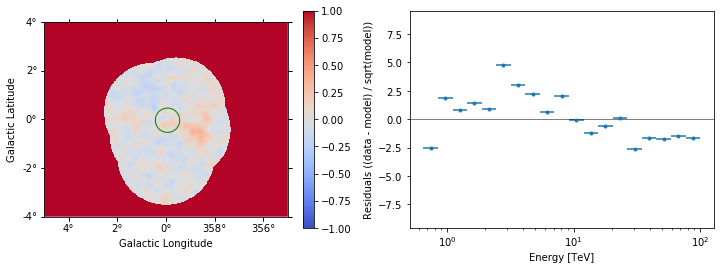

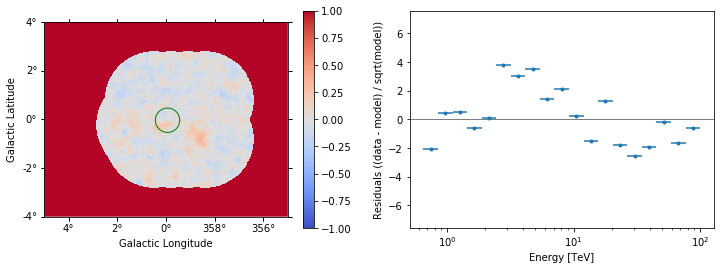

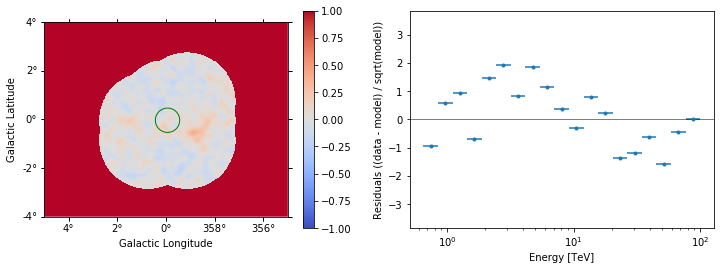

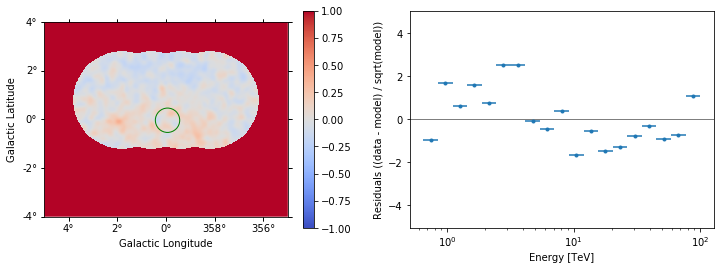

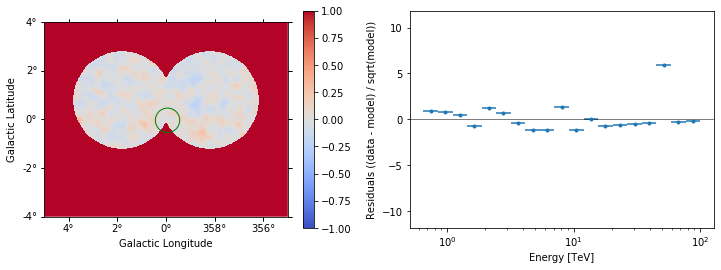

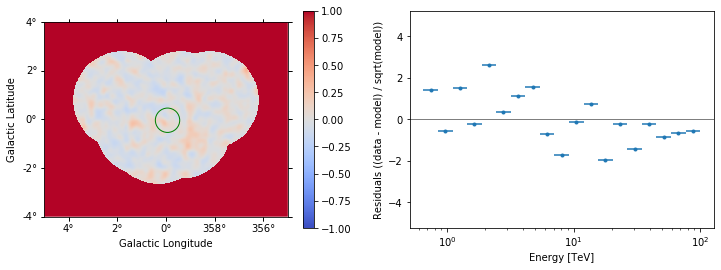

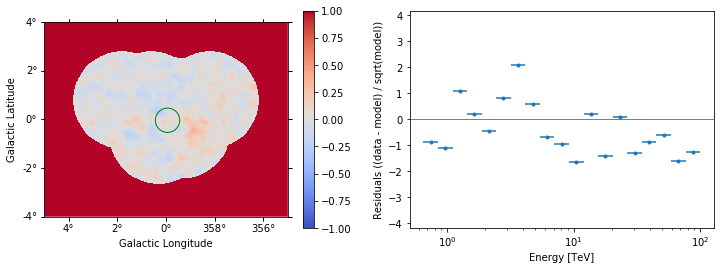

In [20]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in range(2004,2020):
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    plt.savefig("../../../hess_results/DE_3comp_in1_bkg-peak/residuals/residuals_"+str(year)+".pdf", overwrite=True)


## Etude de l'évolution temporelle de la source/du diffus

In [39]:
def CalculateFluxFromModels(year, emin, emax):
    GC_model, G09, DE_model  = mapdataset_dict[year].models
    
    amplitudeGC = results_per_year[year]['value'][3]
    amp_errGC = results_per_year[year]['error'][3]
    amplitudediff = results_per_year[year]['value'][12]
    amp_errdiff = results_per_year[year]['error'][12]

    norm = results_per_year[year]['value'][14]
    norm_err = results_per_year[year]['error'][14]
    
    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)*solid_angle_tot/u.sr  
        GC_flux = GC_model.spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)
        GC_flux = GC_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff, norm, norm_err

    #diffuse_index = diffuse_model.spectral_model.index.value
    #diffuse_amp = diffuse_model.spectral_model.amplitude.value
    
    #GC_index = GC_model.spectral_model.index.value
    #GC_amp = GC_model.spectral_model.amplitude.value
     

In [40]:
print(results_per_year[2004][14])

name   value     error   unit    min    max frozen
---- --------- --------- ---- --------- --- ------
norm 9.018e-01 7.848e-03      0.000e+00 nan  False


## Tracé de l'évolution

Problèmes actuels :
- l'émission diffuse varie trop (au moins du simple au double)
- l'émission diffuse n'est plus calculabe à partir de 2017
- l'émission diffuse croit "linéairement" en deux temps, pourquoi ?
- le flux de la source évolue clairement avec le flux du diffus, c'est attendu mais cela implique que les valeurs calculées pour le flux de la source sont faussés.
- le fond a une normalisation qui varie trop apparemment

In [42]:
emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in range(2004,2020):
    dif , GC, amp, amp_err, ampdiff, amp_errdiff, norm, norm_err = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    norms.append(norm)
    norms_err.append(norm_err)

    


resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiffDGC = np.asarray(ampsdiffDGC)
amp_errsdiffDGC = np.asarray(amp_errsdiffDGC)
norms = np.asarray(norms)
norms_err = np.asarray(norms_err)

### Calcul des erreurs sur les flux et les raports de flux

In [43]:
yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff


bizar = []
for k in range(16):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    bizar.append(truc)
    
# erreurs quadratiques trop simplistes car les jeux de données sont corrélées
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 -bizar )

### Graphes des différents flux (les données importantes)

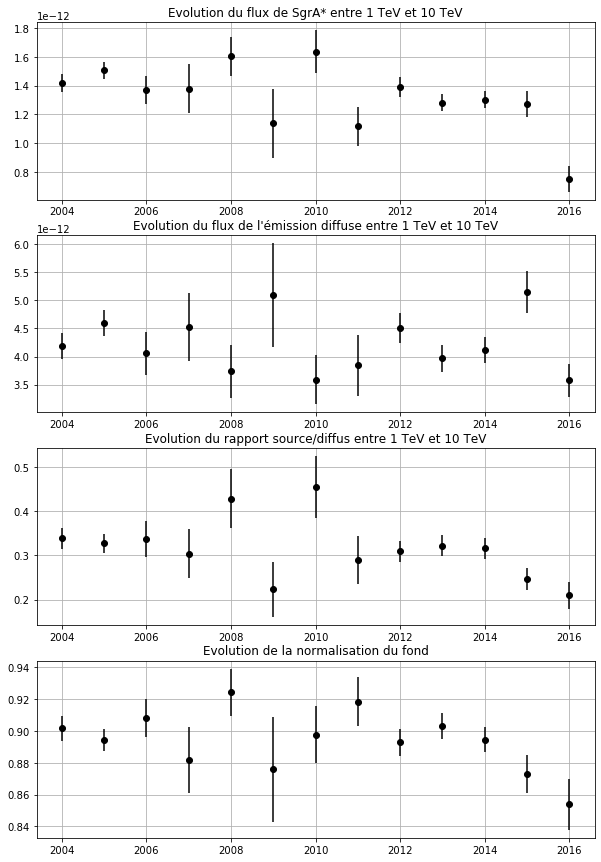

In [44]:
plt.figure(figsize=(10,15))

ax1 = plt.subplot(4,1,1)

plt.errorbar(range(2004,2017) , resGC[0:13], yerr=yerrGC[0:13], fmt='ko')# ax=ax1)
plt.title("Evolution du flux de SgrA* entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,2)
plt.errorbar(range(2004,2017) , resdiff[0:13], yerr=yerrdiff[0:13], fmt='ko')
plt.title("Evolution du flux de l'émission diffuse entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,3)
plt.errorbar(range(2004,2017) , resGC[0:13]/resdiff[0:13], yerr=yerr_rap[0:13], fmt='ko')
plt.title("Evolution du rapport source/diffus entre 1 TeV et 10 TeV")
plt.grid()


ax4 = plt.subplot(4,1,4)
plt.errorbar(range(2004,2017) , norms[0:13], yerr=norms_err[0:13], fmt='ko')# ax=ax1)
plt.title("Evolution de la normalisation du fond")
plt.grid()

plt.savefig("../../../hess_results/DE_3comp_in1_bkg-peak/GCDEflux_evolution_04_16.pdf")

### Evolution des amplitudes des trois composantes de l'émission diffuse

ValueError: shape mismatch: objects cannot be broadcast to a single shape

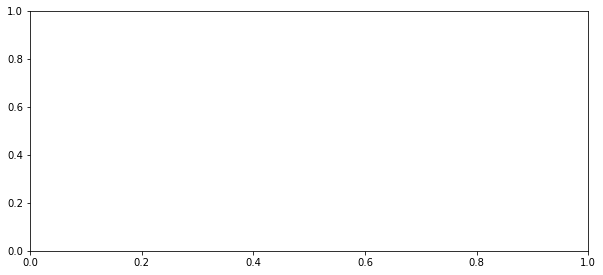

In [45]:
plt.figure(figsize=(10,15))

ax1 = plt.subplot(3,1,1)

plt.errorbar(range(2004,2017) , ampsdiffDGC[0:13], yerr=amp_errsdiffDGC[0:13], fmt='ko')# ax=ax1)
plt.title("Amplitude de la DGC")
plt.grid()

ax2 = plt.subplot(3,1,2)
plt.errorbar(range(2004,2017) , ampsdiffLSC[0:13], yerr=amp_errsdiffLSC[0:13], fmt='ko')
plt.title("Amplitude de la LSC")
plt.grid()

ax2 = plt.subplot(3,1,3)
plt.errorbar(range(2004,2017) , ampsdiffCC[0:13], yerr=amp_errsdiffCC[0:13], fmt='ko')
plt.title("Amplitude de la CC")
plt.grid()

plt.savefig("../../../hess_results/DE_3comp_in1_bkg-peak/DE_3comp_evolution_04_16.pdf")

## Ajustement du modèle d'évolution grâce à astropy

In [46]:
import scipy.stats as stats

from astropy.modeling import models, fitting

def chisq(obs, exp):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(exp**2)
    return chisq


def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr

### Ajustement de l'évolution de la source

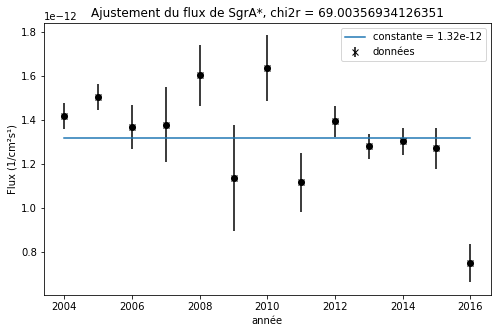

In [48]:
x = range(2004,2020)
y = resGC
y_uncs = yerrGC

x = np.delete(x, [13,14,15])
y = np.delete(y, [13,14,15])
y_uncs = np.delete(y_uncs, [13,14,15])


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = np.delete(resGC, [13,14,15])
A2 = t(2004)
err_bars = yerrGC
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de SgrA*, chi2r = " + str(chi2r))
plt.savefig("../../../hess_results/DE_3comp_in1_bkg-peak/fit_flux_SgrAstar_04_16.pdf")

### Ajustement de l'émission diffuse

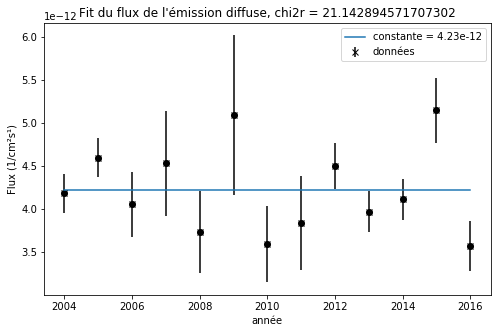

In [50]:
x = range(2004,2020)
y = resdiff
y_uncs = yerrdiff

x = np.delete(x, [13,14,15])
y = np.delete(y, [13,14,15])
y_uncs = np.delete(y_uncs, [13,14,15])


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)#, weights=1.0/y_uncs)

A1 = np.delete(resdiff, [13,14,15])
A2 = t(2004)
err_bars = yerrdiff
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fit du flux de l'émission diffuse, chi2r = " + str(chi2r))
plt.savefig("../../../hess_results/DE_3comp_in1_bkg-peak/fit_flux_DE_04_16.pdf")

### On regarde le rapport entre les 2

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


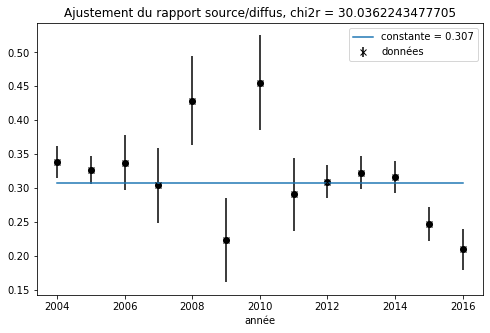

In [51]:
x = range(2004,2020)
y = resGC/resdiff

bizar = []
for k in range(16):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    bizar.append(truc)
    
# erreurs quadratiques trop simplistes car les jeux de données sont corrélées
y_uncs = y*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 - bizar )

x = np.delete(x, [13,14,15])
y = np.delete(y, [13,14,15])
y_uncs = np.delete(y_uncs, [13,14,15])

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = np.delete(y, [13,14,15])
A2 = t(2004)
err_bars = y_uncs
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 3)) )
plt.xlabel('année')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Ajustement du rapport source/diffus, chi2r = " + str(chi2r))
plt.savefig("../../../hess_results/DE_3comp_in1_bkg-peak/fit_flux_GCsurDE_04_16.pdf")

In [150]:
cov_per_year[2004][0,1]

-1.9394799580837315e-25

## Autres choses

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f6d5aa01828>)

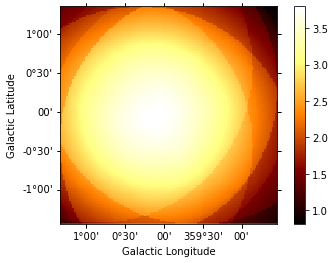

In [56]:
mapdataset_dict[2004].models[2].parameters['amplitude'].value = 0

mapdataset_dict[2004].npred().sum_over_axes().cutout(src_pos,2.8*u.deg).plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f6d5a4544e0>)

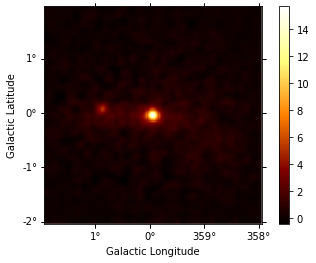

In [57]:
mapdataset_dict[2004].residuals().sum_over_axes().cutout(src_pos,4*u.deg).smooth(width=0.05*u.deg).plot(add_cbar=True)

In [58]:
results_per_year[2004]

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,1.940e-12,8.192e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,8.791e-01,0.000e+00,deg,nan,nan,True
lat_0,8.930e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,6.710e-13,5.594e-14,cm-2 s-1 TeV-1,nan,nan,False
